# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [75]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, \
mean_squared_error, r2_score, mean_absolute_error, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from faker import Faker


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [15]:
data = pd.read_csv('../Dataset/train.csv')
data = data.drop(columns=['id'])

data_test = pd.read_csv('../Dataset/test.csv')
data_test = data_test.drop(columns=['id'])

data

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


# 3. Initial Analysis

### 3.1. Metadata

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [13]:
data.isnull().sum()

label    0
tweet    0
dtype: int64

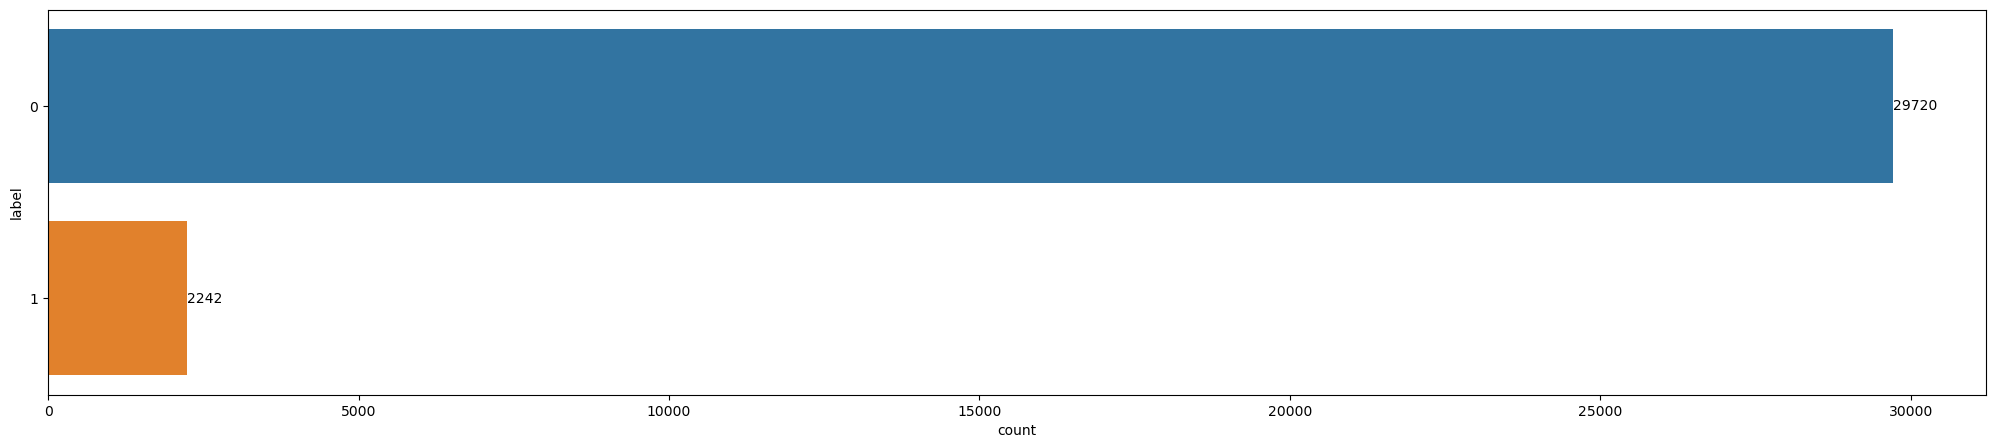

In [14]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, y = data['label'])
ax.bar_label(ax.containers[0])
plt.show()

### 3.2. Processing Columns

In [21]:
stopword_en = pd.read_csv('../../en_stopword_1106.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@[a-z0-9_]+', '', text) # Removes Twitter usernames
    text = re.sub('rt|cc', ' ', text)  # remove RT and cc
    text = re.sub('#\S+', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('\[.*?\]', '', text) # Removes all text enclosed in square brackets 
    text = re.sub('<.*?>+', '', text) # remove html tags
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuations
    text = re.sub(r'[^\w\s.,]', '', text) # Removes all non-word characters
    # text = [word for word in text.split(' ') if word not in nltk_stopword]
    return text


repl_list = ['s/o','d/o','w/o','/','&',',','-']

def clean_data(name):
	name = str(name).lower()
	name = (''.join(i for i in name if ord(i)<128)).strip()
	for repl in repl_list:
		name = name.replace(repl," ")
	if '@' in name:
		pos = name.find('@')
		name = name[:pos].strip()
	name = name.split(" ")
	name = " ".join([each.strip() for each in name])
	return name

def remove_records(merged_data):
	merged_data['delete'] = 0
	merged_data.loc[merged_data['name'].str.find('with') != -1,'delete'] = 1	
	merged_data.loc[merged_data['count_words']>=5,'delete']=1
	merged_data.loc[merged_data['count_words']==0,'delete']=1
	merged_data.loc[merged_data['name'].str.contains(r'\d') == True,'delete']=1
	cleaned_data = merged_data[merged_data.delete==0]
	return cleaned_data

def stop_word(text):
    return " ".join([word for word in text.split(' ') if word not in nltk_stopword])

lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence) 
    words = [word for word in words if word.isalnum()] 
    words = [lemmatize_word(word) for word in words]  
    return ' '.join(words)  

In [22]:
data['clean_text'] = data['tweet'] \
                    .progress_apply(clean_text) \
                    .progress_apply(stop_word) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(alphanumeric_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data.head()

  0%|          | 0/31962 [00:00<?, ?it/s]

  0%|          | 0/31962 [00:00<?, ?it/s]

  0%|          | 0/31962 [00:00<?, ?it/s]

,label,tweet,clean_text
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunction
1,0,@user @user thanks for #lyft credit i can't us...,thank credit cant use cause dont offer wheelch...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,love u take u time urð ðððð ððð
4,0,factsguide: society now #motivation,factsguide society


<Axes: xlabel='text_len'>

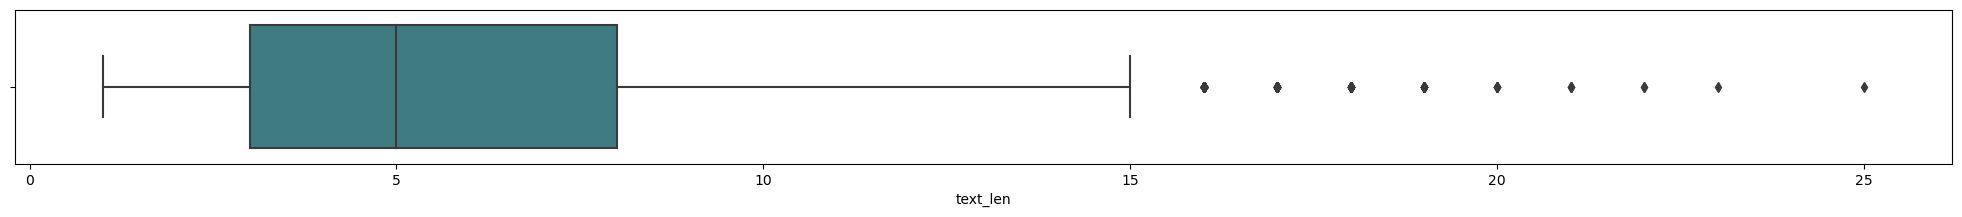

In [23]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [32]:
print(data['text_len'].quantile(.25))
print(data['text_len'].quantile(1.))

9.0
57.0


<Axes: xlabel='text_len'>

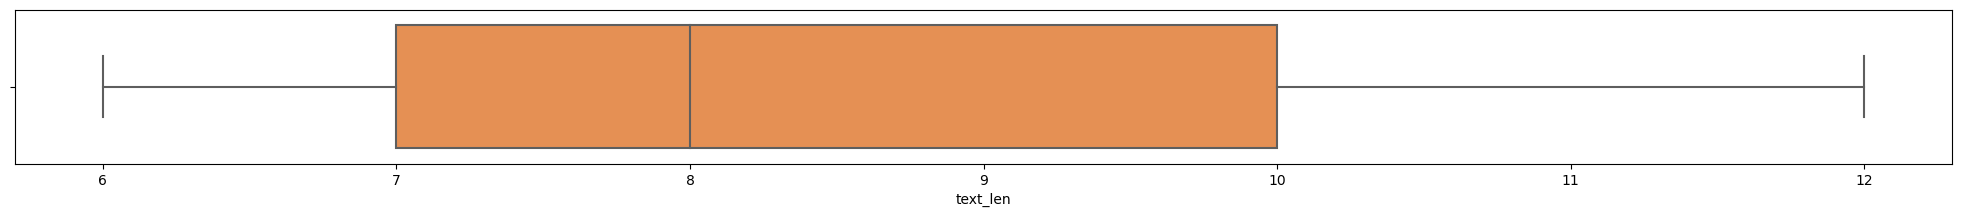

In [16]:
Q1 = data['text_len'].quantile(.25)
Q3 = data['text_len'].quantile(.75)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

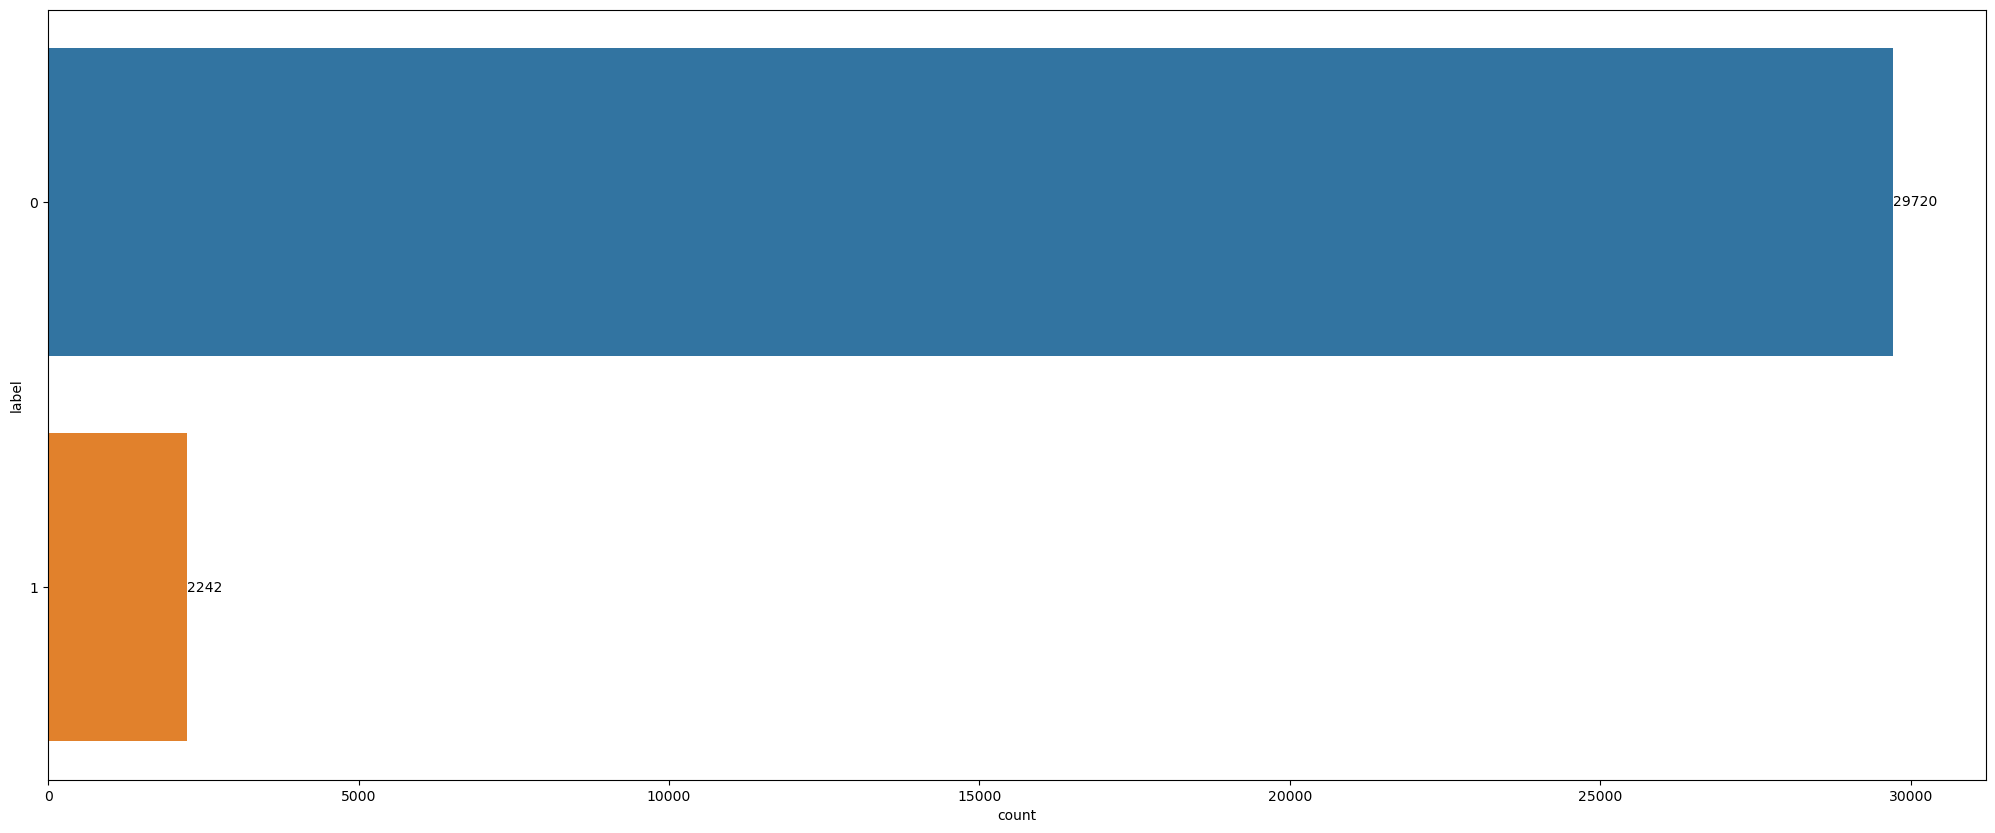

In [24]:
plt.subplots(figsize = (25,10))
ax = sns.countplot(data, y = data['label'])
ax.bar_label(ax.containers[0])
plt.show()

# 4. Preparing Dataset

In [69]:
LE = LabelEncoder()

X = data['clean_text']
# Y = LE.fit_transform(data['label']) ### For Classification Algoritms
# Y = pd.get_dummies(data['label']) ### For Deep Learning Algoritms
Y = data['label'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(22436,) (22436,)
(6329,) (6329,)
(3197,) (3197,)


In [38]:
vocab_size = 10_000
embedding_dim = 256
max_length = 25
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
num_label = y_train.shape[1]

In [ ]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

In [70]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# Categorical Label
# training_label = pd.get_dummies(training_label.reshape(-1)).values
# testing_label = pd.get_dummies(testing_label.reshape(-1)).values
# validating_label = pd.get_dummies(validating_label.reshape(-1)).values

print(training_padded.shape)
print(testing_padded.shape)
print(validating_padded.shape)


23260
(3200, 25)
(858, 25)
(426, 25)


# 5. Deep Learning Model

In [62]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(num_label, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(num_label, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.000_005)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 25, 256)           2560000   
                                                                 
 bidirectional_12 (Bidirecti  (None, 25, 512)          789504    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 512)              1182720   
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 4,533,250
Trainable params: 4,533,250
Non-trainable params: 0
_________________________________________________________________


In [63]:
num_epoch = 60
batch_size = 64
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/60
50/50 [==============================] - 5s 41ms/step - loss: 0.6922 - accuracy: 0.5544 - val_loss: 0.6919 - val_accuracy: 0.5610
Epoch 2/60
50/50 [==============================] - 1s 25ms/step - loss: 0.6914 - accuracy: 0.5675 - val_loss: 0.6913 - val_accuracy: 0.5681
Epoch 3/60
50/50 [==============================] - 1s 25ms/step - loss: 0.6905 - accuracy: 0.5859 - val_loss: 0.6906 - val_accuracy: 0.5610
Epoch 4/60
50/50 [==============================] - 1s 24ms/step - loss: 0.6896 - accuracy: 0.5938 - val_loss: 0.6900 - val_accuracy: 0.5634
Epoch 5/60
50/50 [==============================] - 1s 24ms/step - loss: 0.6887 - accuracy: 0.6012 - val_loss: 0.6892 - val_accuracy: 0.5728
Epoch 6/60
50/50 [==============================] - 1s 23ms/step - loss: 0.6876 - accuracy: 0.6047 - val_loss: 0.6884 - val_accuracy: 0.5751
Epoch 7/60
50/50 [==============================] - 1s 23ms/step - loss: 0.6865 - accuracy: 0.6056 - val_loss: 0.6876 - val_accuracy: 0.5704
Epoch 8/60
50

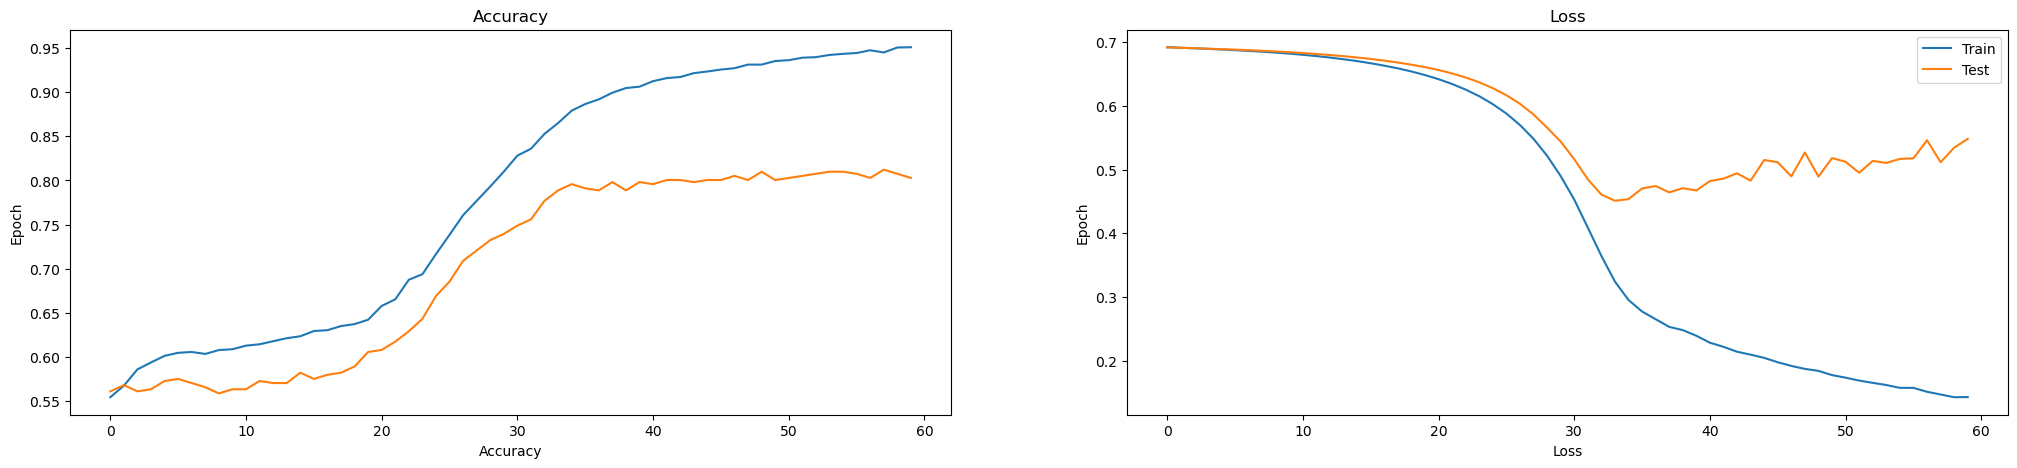

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [65]:
train_predictions = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                  0        0   True
1                  0        0   True
2                  1        0  False
3                  0        0   True
4                  0        0   True


True     666
False    192
Name: Diff, dtype: int64

In [66]:
y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
print(classification_report(testing_label.argmax(axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       429
           1       0.78      0.77      0.77       429

    accuracy                           0.78       858
   macro avg       0.78      0.78      0.78       858
weighted avg       0.78      0.78      0.78       858



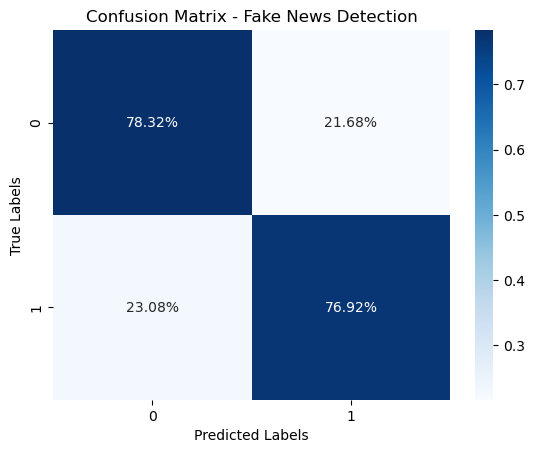

In [67]:
labels = y_train.columns

y_pred = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [71]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
linear = LinearRegression()
pac = PassiveAggressiveClassifier(random_state=42)

model = StackingClassifier([
    ('XGB', XGB),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('extraTres', extraTrees),
    ('knn', knn),
    ('decisionTree', decisionTree),
    # ('pac', pac),
    # ('linear', linear),
    # ('gradient', gradient),

], n_jobs=-1)

In [72]:
model.fit(training_padded, training_label)

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTres',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('knn', KNeighborsClassifier(n_jobs=-1)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       random_state=42))],
                   n_jobs=-1)

In [76]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(testing_label, y_pred), 2))

Train Score        : 99.69 %
Test Score         : 67.83 %
R Squared Error    : -0.29
Mean Squared Error : 0.32
Mean Absolute Error: 0.32


In [74]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                  0        0   True
1                  0        0   True
2                  1        0  False
3                  1        0  False
4                  0        0   True


True     582
False    276
Name: Diff, dtype: int64

In [77]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       393
           1       0.72      0.66      0.69       465

    accuracy                           0.68       858
   macro avg       0.68      0.68      0.68       858
weighted avg       0.68      0.68      0.68       858



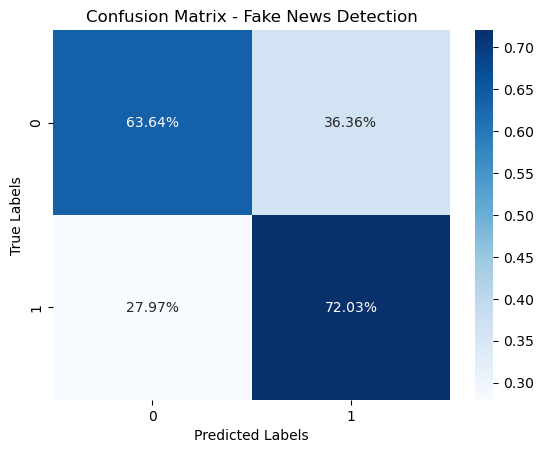

In [78]:
# labels = ['Fake','Real']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()